# KNN and DT


In [1]:
#import libraries
import numpy as np
import pandas as pd
#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scipy
from scipy.stats.mstats import winsorize
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#importing dataset
files_dir = "../dataset/"
filename = files_dir + "AB_NYC_2019.csv"
df_original = pd.read_csv(filename)
df = df_original.copy(deep = True)
#data types
for _ in ['id','host_id']:
  df[_] = df[_].astype('object')
df_missing = df.copy(deep=True)
#dropping irrelevant columns
df_missing.drop(['host_id','host_name'], axis=1, inplace=True)
#replacing missing values
df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())] = df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())].replace(np.nan,0)
#dropping irrelevant columns
df_missing.drop(['last_review'], axis=1, inplace=True)
#dropping rows with NaN in listing names
df_missing.dropna(subset = ['name'], inplace= True)
df_missing['name'] = df_missing.name.astype('str')

#winsorize the outliers
df_win = df_missing.copy(deep=True)
df_win['minimum_nights'] = winsorize(df_missing['minimum_nights'], limits=(0, 0.075))
df_win['number_of_reviews'] = winsorize(df_missing['number_of_reviews'], limits=(0, 0.075))
df_win['reviews_per_month'] = winsorize(df_missing['reviews_per_month'], limits=(0, 0.075))
df_win['calculated_host_listings'] = winsorize(df_missing['calculated_host_listings_count'], limits=(0, 0.075))
df_win['availability_365'] = winsorize(df_missing['availability_365'], limits=(0, 0.075))

#feature encoding
df_dummies = pd.get_dummies(df_win, columns = ['neighbourhood_group'],
                                          prefix = 'NG',drop_first=True)

df_dummies = pd.get_dummies(df_dummies, columns = ['room_type'],
                                          drop_first=True)
df_dummies.drop(['neighbourhood'], axis=1, inplace=True)

# #feature scaling
def scaler_transform(scaler_type, X, exclude_vars = ['latitude', 'longitude', 'id','NG_Brooklyn','NG_Manhattan','NG_Queens','NG_Bronx','NG_Staten Island','room_type_Private room','room_type_Shared room']):
    '''
    Transform the NON-object type data to the selected scaler
    '''
    X_copy = X.copy(deep = True)
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    X_notexcluded= X_copy.loc[:, ~X_copy.columns.isin(exclude_vars)]
    X_withoutobj = X_notexcluded.select_dtypes(exclude=['object'])
    X_withoutobj = X_withoutobj.add_suffix(f'_{scaler_type}')
    # Fit transform the scaler if there are objects in dataset
    if X_withoutobj.shape[1] > 0:
        X_withoutobj = pd.DataFrame(scaler.fit_transform(X_withoutobj[X_withoutobj.columns]),
                                        index=X_withoutobj.index,
                                        columns=X_withoutobj.columns)
        # Concatenate the rest of the data
        X_withexcl = pd.concat([X_withoutobj, X.loc[:, X.columns.isin(exclude_vars)]], axis=1)
        others = [x for x in X.select_dtypes('object') if x not in X_withexcl.columns]
        X_final = pd.concat([X_withexcl,X[others]], axis=1)
    return X_final
  
df_scaled = scaler_transform('standard', df_dummies)

In [2]:
df  = df_scaled.copy(deep=True)

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from utils_func import decision_boundary_plot, inverse_get_dummies

In [5]:
#discretizing the label price
#Preparation
from sklearn.preprocessing import KBinsDiscretizer,LabelEncoder
trans = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['price_bins'] = trans.fit_transform(np.array(df['price_standard']).reshape(-1,1))

In [6]:
trans.bin_edges_[0]

array([-6.35891733e-01, -3.02787937e-01, -1.13221155e-02,  4.10020827e+01])

In [7]:
df = inverse_get_dummies(df[[
       'room_type_Private room', 'room_type_Shared room']], df.loc[:,~df.columns.isin(['room_type_Private room', 'room_type_Shared room'])], 'room_type')
df['room_type'].fillna('room_type_Entire home/apt', inplace=True)
df['room_type'] = df['room_type'].map({'room_type_Shared room':0, 'room_type_Private room':1,'room_type_Entire home/apt':2})
df['room_type'].unique()

array([1, 2, 0])

In [8]:
df['price_bins'] = df['price_bins'].map({0:'low', 1:'med',2:'high'})
df['price_bins'].unique()

array(['med', 'high', 'low'], dtype=object)

In [9]:
df['price_bins'] = df['price_bins'].map({'low':0, 'med':1,'high':2})
df['price_bins'].unique()

array([1, 2, 0])

In [49]:
y = df['price_bins']
#X = df_class.drop(['neighbourhood_group','name','id'], axis=1)
X = df.drop(['price_bins','price_standard','name','id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## KNN

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#baseline classifier that predicts the most commmon label and compare metrics
from sklearn.dummy import DummyClassifier
from  sklearn.neighbors import KNeighborsClassifier as KNN
dummy_clf = DummyClassifier(strategy="most_frequent")
#5-NN classifier
knn_5_unif = KNN(n_neighbors=5)
knn_5_dist = KNN(n_neighbors=5, weights = 'distance')
# 11-NN classifier
knn_11_unif = KNN(n_neighbors=11)
knn_11_dist = KNN(n_neighbors=11, weights = 'distance')
# 15-NN classifier
knn_15_unif = KNN(n_neighbors=15)
knn_15_dist = KNN(n_neighbors=15, weights = 'distance')

In [51]:
X_dec_bound = df[['room_type','minimum_nights_standard']]
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(X_dec_bound, y, test_size=0.33, random_state=42)

In [52]:
knn_15_unif.fit(X_train_db,y_train_db)

KNeighborsClassifier(n_neighbors=15)

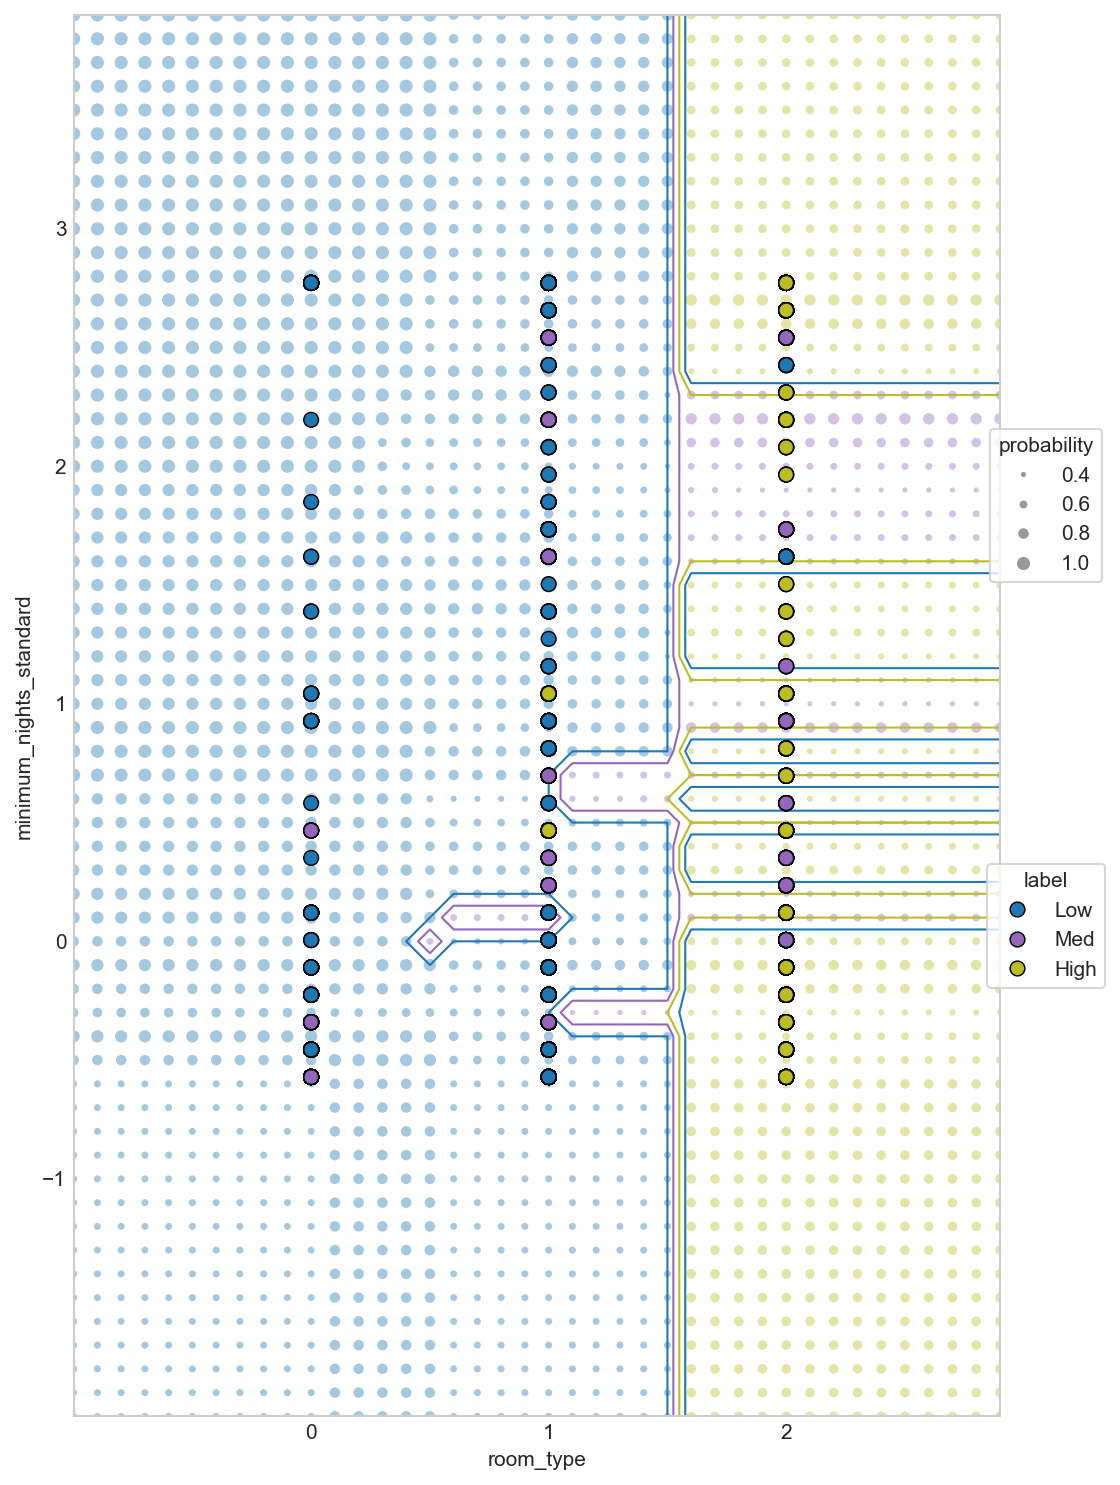

In [53]:
decision_boundary_plot(knn_15_unif, X_train_db, y_train_db, classes=[ 'Low','Med', 'High'], h=0.1, prob_dot_scale=40, prob_dot_scale_power=2, true_dot_size=50, pad=1.0)

In [54]:
X_train

,minimum_nights_standard,number_of_reviews_standard,reviews_per_month_standard,calculated_host_listings_count_standard,availability_365_standard,calculated_host_listings_standard,latitude,longitude,NG_Brooklyn,NG_Manhattan,NG_Queens,NG_Staten Island,room_type
44884,-0.570973,-0.612853,0.293694,-0.186463,1.805307,-0.520174,40.78958,-73.97940,0,1,0,0,2
38355,-0.455697,-0.278963,0.409372,-0.186463,-0.075319,-0.520174,40.72573,-73.98841,0,1,0,0,2
34257,-0.570973,0.203321,0.896869,-0.186463,1.558668,-0.520174,40.79729,-73.93092,0,1,0,0,2
12804,-0.570973,-0.687050,-0.805239,-0.186463,-0.861483,-0.520174,40.72745,-73.98979,0,1,0,0,1
37069,-0.570973,-0.538655,-0.342530,-0.156118,1.813015,-0.032031,40.58056,-73.96313,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11287,-0.570973,-0.687050,-0.805239,-0.186463,-0.861483,-0.520174,40.86711,-73.89525,0,0,0,0,1
44738,2.772028,-0.687050,-0.805239,6.823279,1.520130,2.896827,40.71634,-74.00694,0,1,0,0,2
38164,2.772028,-0.575754,-0.466470,-0.186463,0.379423,-0.520174,40.75693,-73.96583,0,1,0,0,2
860,-0.455697,-0.278963,-0.697825,-0.186463,-0.846068,-0.520174,40.77508,-73.97990,0,1,0,0,2


In [55]:
#accuracy calculation
for clf,clf_name in zip([dummy_clf,knn_5_unif, knn_5_dist,knn_11_unif, knn_11_dist, knn_15_unif, knn_15_dist],['dummy_clf','knn_5_unif','knn_5_dist','knn_11_unif','knn_11_dist','knn_15_unif','knn_15_dist']):
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print(f'classifier: {clf_name} accuracy_score: {accuracy_score(y_test, yhat)}')
    print(f'classifier: {clf_name} precision_score: {precision_score(y_test, yhat, average="weighted")}')
    print(f'classifier: {clf_name} recall_score: {recall_score(y_test, yhat, average="weighted")}')
    print(f'classifier: {clf_name} f1_score: {f1_score(y_test, yhat, average="weighted")}')

classifier: dummy_clf accuracy_score: 0.34641130531796205
classifier: dummy_clf precision_score: 0.12000079245209433
classifier: dummy_clf recall_score: 0.34641130531796205
classifier: dummy_clf f1_score: 0.17825279983631082
classifier: knn_5_unif accuracy_score: 0.623961819759514
classifier: knn_5_unif precision_score: 0.6172932626866103
classifier: knn_5_unif recall_score: 0.623961819759514
classifier: knn_5_unif f1_score: 0.6192582436013883
classifier: knn_5_dist accuracy_score: 0.6225982397421594
classifier: knn_5_dist precision_score: 0.6172307527769735
classifier: knn_5_dist recall_score: 0.6225982397421594
classifier: knn_5_dist f1_score: 0.6194886815092261
classifier: knn_11_unif accuracy_score: 0.6418123218048841
classifier: knn_11_unif precision_score: 0.6337832111144404
classifier: knn_11_unif recall_score: 0.6418123218048841
classifier: knn_11_unif f1_score: 0.6363919782357954
classifier: knn_11_dist accuracy_score: 0.6423081690839222
classifier: knn_11_dist precision_score

In [56]:
#test-training learning curve for each kNN and check low/high variance model. 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from utils_func import plot_learning_curve

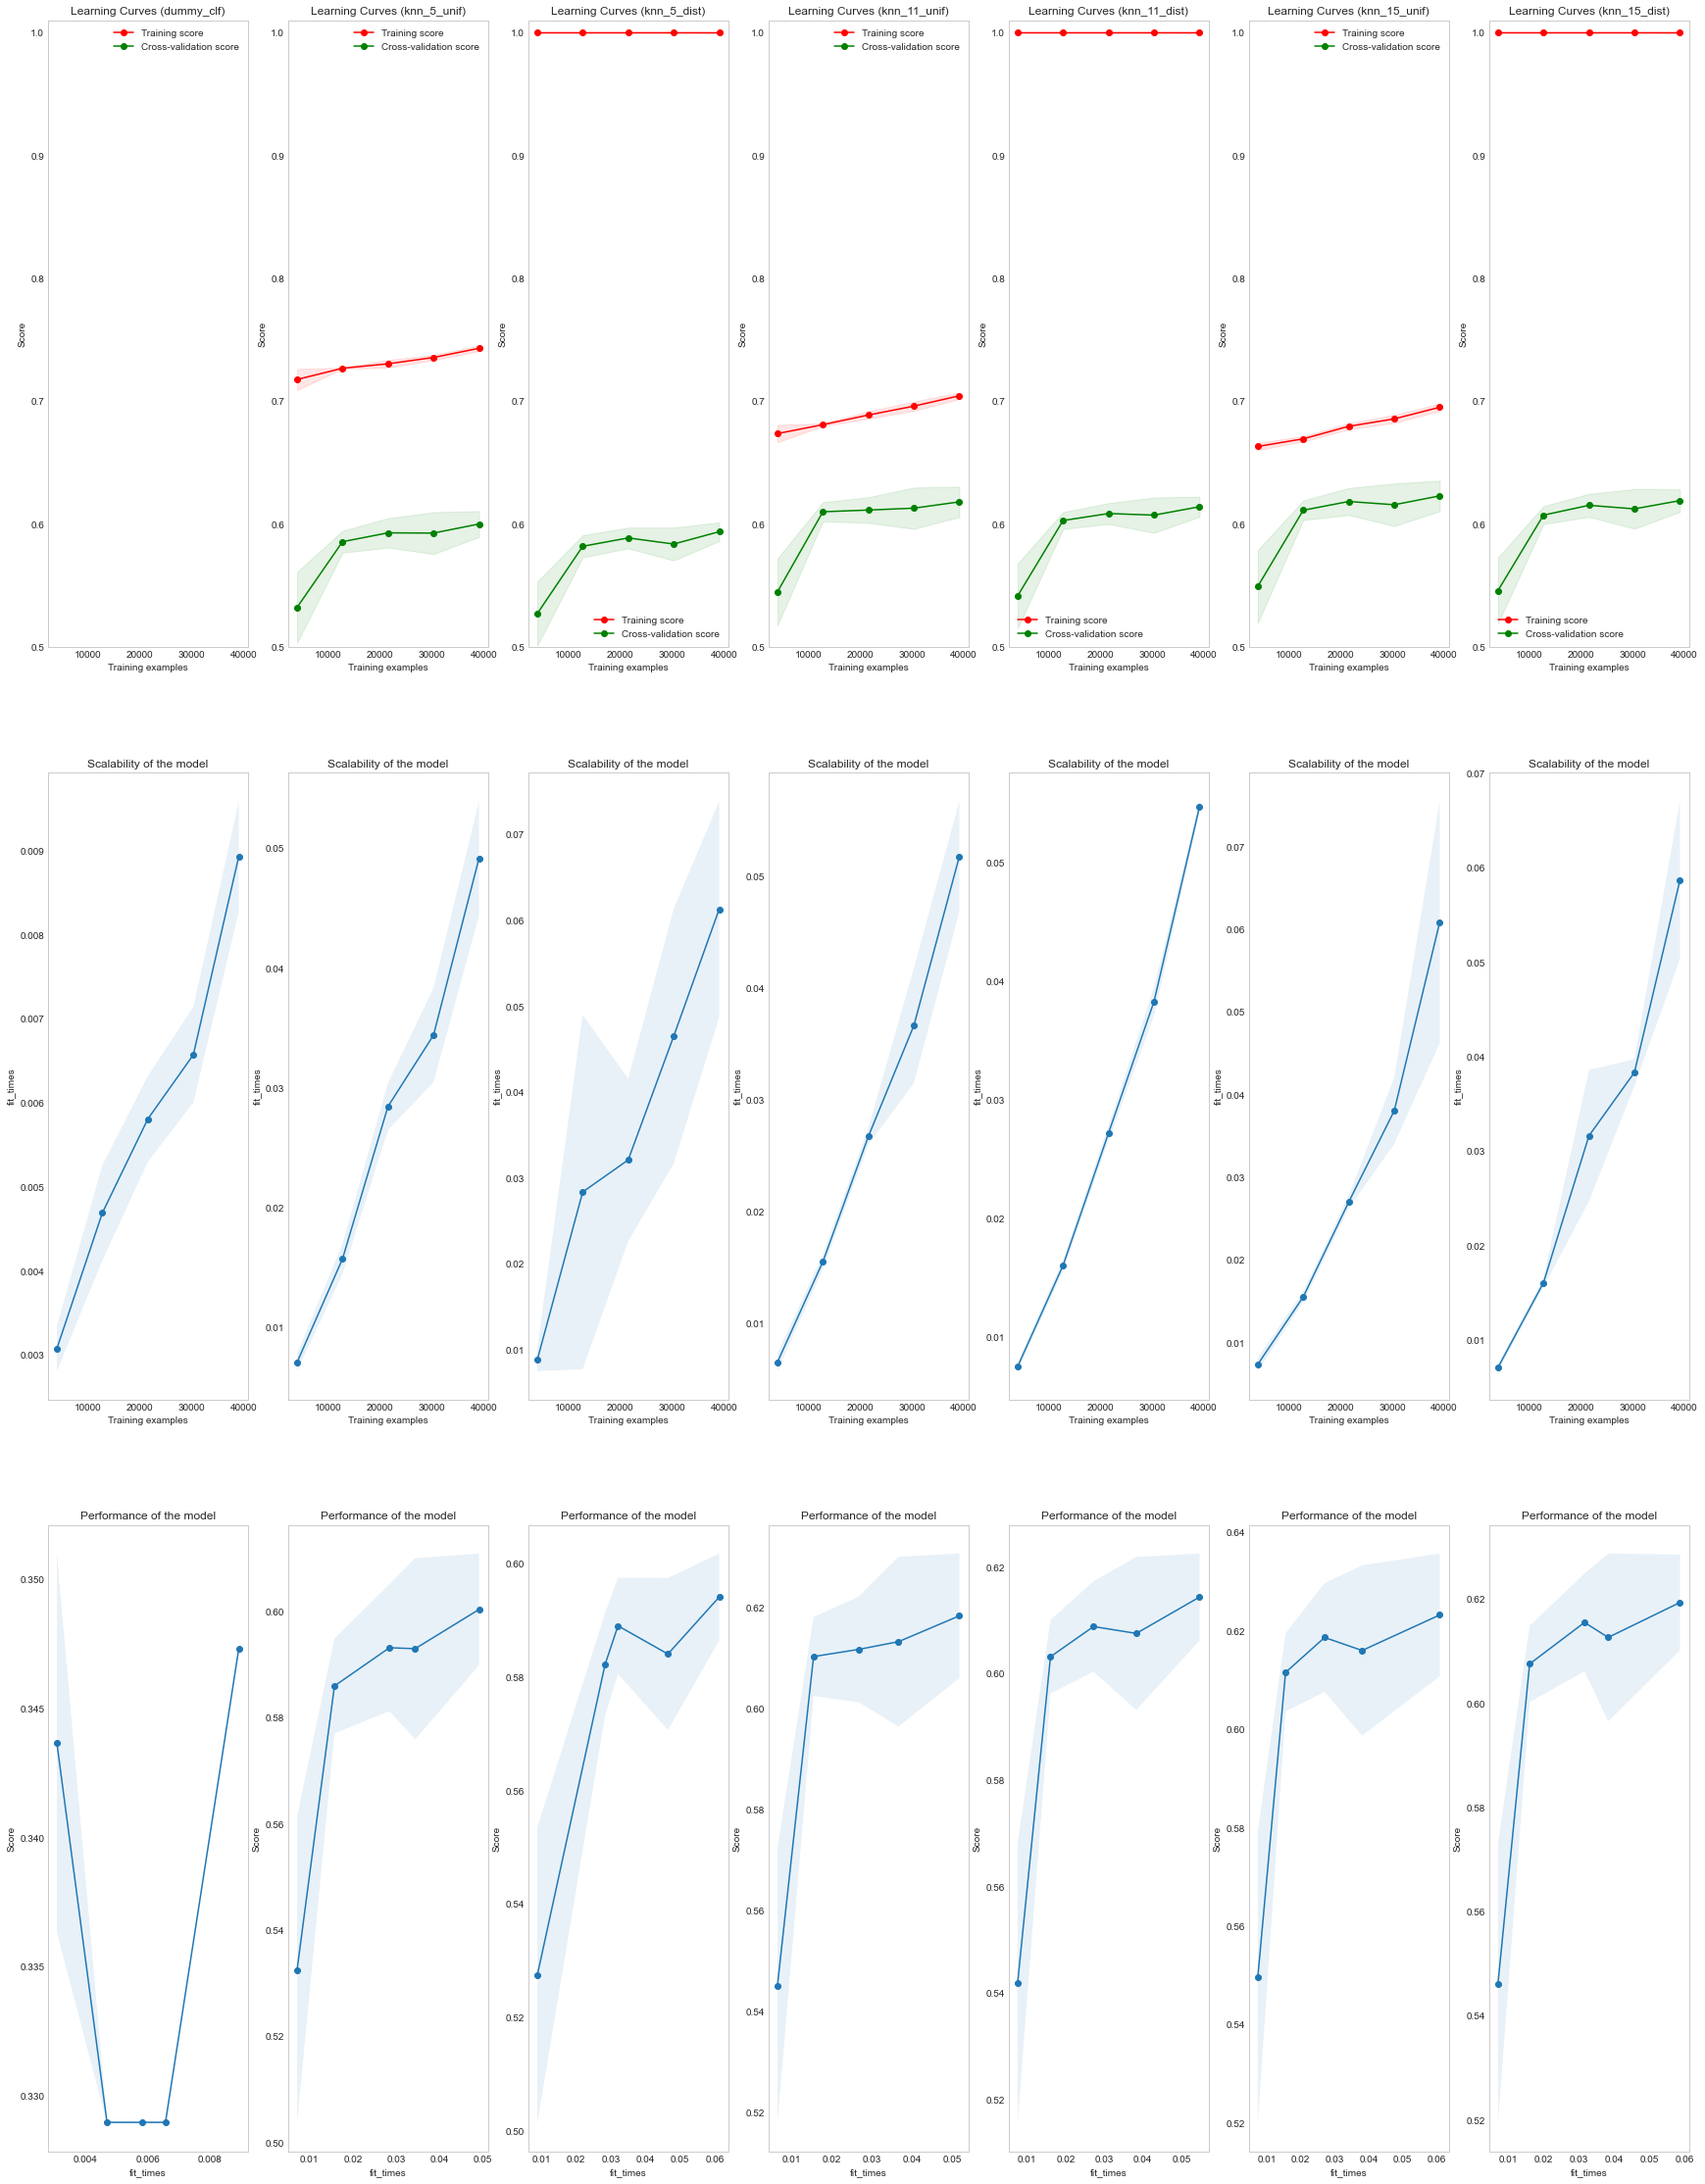

In [67]:
fig, axes = plt.subplots(3, 7, figsize=(30, 40))
cv = StratifiedKFold(n_splits=5)
for (i,estimator),estimator_name in zip(enumerate([dummy_clf,knn_5_unif, knn_5_dist,knn_11_unif, knn_11_dist, knn_15_unif, knn_15_dist]),['dummy_clf','knn_5_unif','knn_5_dist','knn_11_unif','knn_11_dist','knn_15_unif','knn_15_dist']):
    title = f"Learning Curves ({estimator_name})"
    plot_learning_curve(
        estimator, title, X, y, axes=axes[:, i], ylim=(0.5, 1.01), cv=cv, n_jobs=4)

In [59]:
from sklearn.tree import DecisionTreeClassifier
rs = 42

In [68]:
df_gini = DecisionTreeClassifier(criterion = 'gini', random_state=rs)
df_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state=rs)
df_best = DecisionTreeClassifier(splitter = 'best', random_state=rs)
df_random = DecisionTreeClassifier(splitter = 'random', random_state=rs)
#Concerning internal node splits, this parameter signifies the minimum sample number required for the split.
df_min_split3 = DecisionTreeClassifier(min_samples_split = 3, random_state=rs) 
df_min_split10 = DecisionTreeClassifier(min_samples_split = 10, random_state=rs)
#Concerning leaf nodes, this is the minimum sample number required at leaf nodes.
df_min_leaf1 = DecisionTreeClassifier(min_samples_leaf = 1, random_state=rs) 
df_min_leaf2 = DecisionTreeClassifier(min_samples_leaf =2, random_state=rs)
df_max_depth4 = DecisionTreeClassifier(max_depth= 4, random_state=rs)
df_max_depth8 = DecisionTreeClassifier(max_depth = 8, random_state=rs)

In [78]:
for clf,clf_name in zip([dummy_clf,df_gini, df_entropy,df_best, df_random, df_min_split3, df_min_split10,
                        df_min_leaf1,df_min_leaf2,df_max_depth4,df_max_depth8 ],
                        ['dummy_clf','df_gini', 'df_entropy','df_best', 'df_random', 'df_min_split3', 'df_min_split10','df_min_leaf1','df_min_leaf2','df_max_depth4','df_max_depth8']):
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print(f'classifier: {clf_name} accuracy_score: {accuracy_score(y_test, yhat)}')

classifier: dummy_clf accuracy_score: 0.34641130531796205
classifier: df_gini accuracy_score: 0.6106359241353663
classifier: df_entropy accuracy_score: 0.614540721457791
classifier: df_best accuracy_score: 0.6106359241353663
classifier: df_random accuracy_score: 0.6059253749845048
classifier: df_min_split3 accuracy_score: 0.6142308169083922
classifier: df_min_split10 accuracy_score: 0.6187554233296145
classifier: df_min_leaf1 accuracy_score: 0.6106359241353663
classifier: df_min_leaf2 accuracy_score: 0.6178257096814181
classifier: df_max_depth4 accuracy_score: 0.6715011776372877
classifier: df_max_depth8 accuracy_score: 0.6796826577414157


In [79]:
for clf,clf_name in zip([dummy_clf,df_gini, df_entropy,df_best, df_random, df_min_split3, df_min_split10,
                        df_min_leaf1,df_min_leaf2,df_max_depth4,df_max_depth8 ],
                        ['dummy_clf','df_gini', 'df_entropy','df_best', 'df_random', 'df_min_split3', 'df_min_split10','df_min_leaf1','df_min_leaf2','df_max_depth4','df_max_depth8']):
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print(f'classifier: {clf_name} precision_score: {precision_score(y_test, yhat, average="weighted")}')

classifier: dummy_clf precision_score: 0.12000079245209433
classifier: df_gini precision_score: 0.6120235632900661
classifier: df_entropy precision_score: 0.6154175251706073
classifier: df_best precision_score: 0.6120235632900661
classifier: df_random precision_score: 0.6063703146595555
classifier: df_min_split3 precision_score: 0.6153333258236778
classifier: df_min_split10 precision_score: 0.6203390318789386
classifier: df_min_leaf1 precision_score: 0.6120235632900661
classifier: df_min_leaf2 precision_score: 0.6197371448196329
classifier: df_max_depth4 precision_score: 0.658533441515875
classifier: df_max_depth8 precision_score: 0.6807763871136261


In [80]:
for clf,clf_name in zip([dummy_clf,df_gini, df_entropy,df_best, df_random, df_min_split3, df_min_split10,
                        df_min_leaf1,df_min_leaf2,df_max_depth4,df_max_depth8 ],
                        ['dummy_clf','df_gini', 'df_entropy','df_best', 'df_random', 'df_min_split3', 'df_min_split10','df_min_leaf1','df_min_leaf2','df_max_depth4','df_max_depth8']):
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print(f'classifier: {clf_name} recall_score: {recall_score(y_test, yhat, average="weighted")}')

classifier: dummy_clf recall_score: 0.34641130531796205
classifier: df_gini recall_score: 0.6106359241353663
classifier: df_entropy recall_score: 0.614540721457791
classifier: df_best recall_score: 0.6106359241353663
classifier: df_random recall_score: 0.6059253749845048
classifier: df_min_split3 recall_score: 0.6142308169083922
classifier: df_min_split10 recall_score: 0.6187554233296145
classifier: df_min_leaf1 recall_score: 0.6106359241353663
classifier: df_min_leaf2 recall_score: 0.6178257096814181
classifier: df_max_depth4 recall_score: 0.6715011776372877
classifier: df_max_depth8 recall_score: 0.6796826577414157


In [81]:
for clf,clf_name in zip([dummy_clf,df_gini, df_entropy,df_best, df_random, df_min_split3, df_min_split10,
                        df_min_leaf1,df_min_leaf2,df_max_depth4,df_max_depth8 ],
                        ['dummy_clf','df_gini', 'df_entropy','df_best', 'df_random', 'df_min_split3', 'df_min_split10','df_min_leaf1','df_min_leaf2','df_max_depth4','df_max_depth8']):
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print(f'classifier: {clf_name} f1_score: {f1_score(y_test, yhat, average="weighted")}')

classifier: dummy_clf f1_score: 0.17825279983631082
classifier: df_gini f1_score: 0.6113025575964144
classifier: df_entropy f1_score: 0.6149669719078303
classifier: df_best f1_score: 0.6113025575964144
classifier: df_random f1_score: 0.6061451225371403
classifier: df_min_split3 f1_score: 0.6146016379519798
classifier: df_min_split10 f1_score: 0.619338713627586
classifier: df_min_leaf1 f1_score: 0.6113025575964144
classifier: df_min_leaf2 f1_score: 0.6176487979815147
classifier: df_max_depth4 f1_score: 0.6596542822993126
classifier: df_max_depth8 f1_score: 0.6797086282539911


In [70]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [71]:
dt_clf = DecisionTreeClassifier(random_state=rs)
kf =KFold(n_splits=10, random_state=rs, shuffle = True)

In [75]:
#Grid search with CV
parameters = {'max_depth': [4,8], 
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [4,8],
              'min_samples_leaf': [4,8,]}
scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(dt_clf, parameters,scoring=scorer, n_jobs = -1 ,cv = kf )

In [76]:
grid_fit = grid_obj.fit(X_train,y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_

In [83]:
results = pd.DataFrame(grid_fit.cv_results_)
# show the first 5 rows
results.sort_values(by='rank_test_score', ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
26,0.304985,0.106172,0.003845,0.000935,entropy,8,4,8,best,"{'criterion': 'entropy', 'max_depth': 8, 'min_...",...,0.680708,0.689866,0.687023,0.681221,0.694351,0.690382,0.685191,0.684446,0.005564,1
24,0.244993,0.024126,0.003990,0.001219,entropy,8,4,4,best,"{'criterion': 'entropy', 'max_depth': 8, 'min_...",...,0.680708,0.689866,0.687023,0.681221,0.694351,0.690382,0.685191,0.684446,0.005564,1
28,0.328486,0.043817,0.005999,0.005704,entropy,8,8,4,best,"{'criterion': 'entropy', 'max_depth': 8, 'min_...",...,0.681929,0.688339,0.683969,0.680305,0.694351,0.691603,0.683053,0.684110,0.005254,3
30,0.233313,0.080500,0.003209,0.001295,entropy,8,8,8,best,"{'criterion': 'entropy', 'max_depth': 8, 'min_...",...,0.681929,0.688339,0.683969,0.680305,0.694351,0.691603,0.683053,0.684110,0.005254,3
14,0.252904,0.076036,0.004171,0.001149,gini,8,8,8,best,"{'criterion': 'gini', 'max_depth': 8, 'min_sam...",...,0.691392,0.683150,0.679084,0.686107,0.683053,0.690382,0.677557,0.683834,0.004406,5


In [88]:
best_clf = grid_fit.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=4,
                       min_samples_split=4, random_state=42)

## Final Decision Tree and evaluation

1. Which feature was used for the first split?
room_type

2. How many leaves are in the optimal classifier/QuAM?



3. Produce a confusion_matrix and describe your QuAM’s accuracy in terms of the
number of true and false positives and negatives.
4. Using scikit-learn’s classification_report method, generate the accuracy, precision,
recall, and f1-score for your model and describe your QuAM’s accuracy.


In [85]:
from sklearn import tree

In [95]:
def get_dt_graph(dt_classifier, classes):
    fig = plt.figure(figsize=(35,40))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=X.columns,
                       class_names=classes,
                       filled=True, fontsize=10)
    

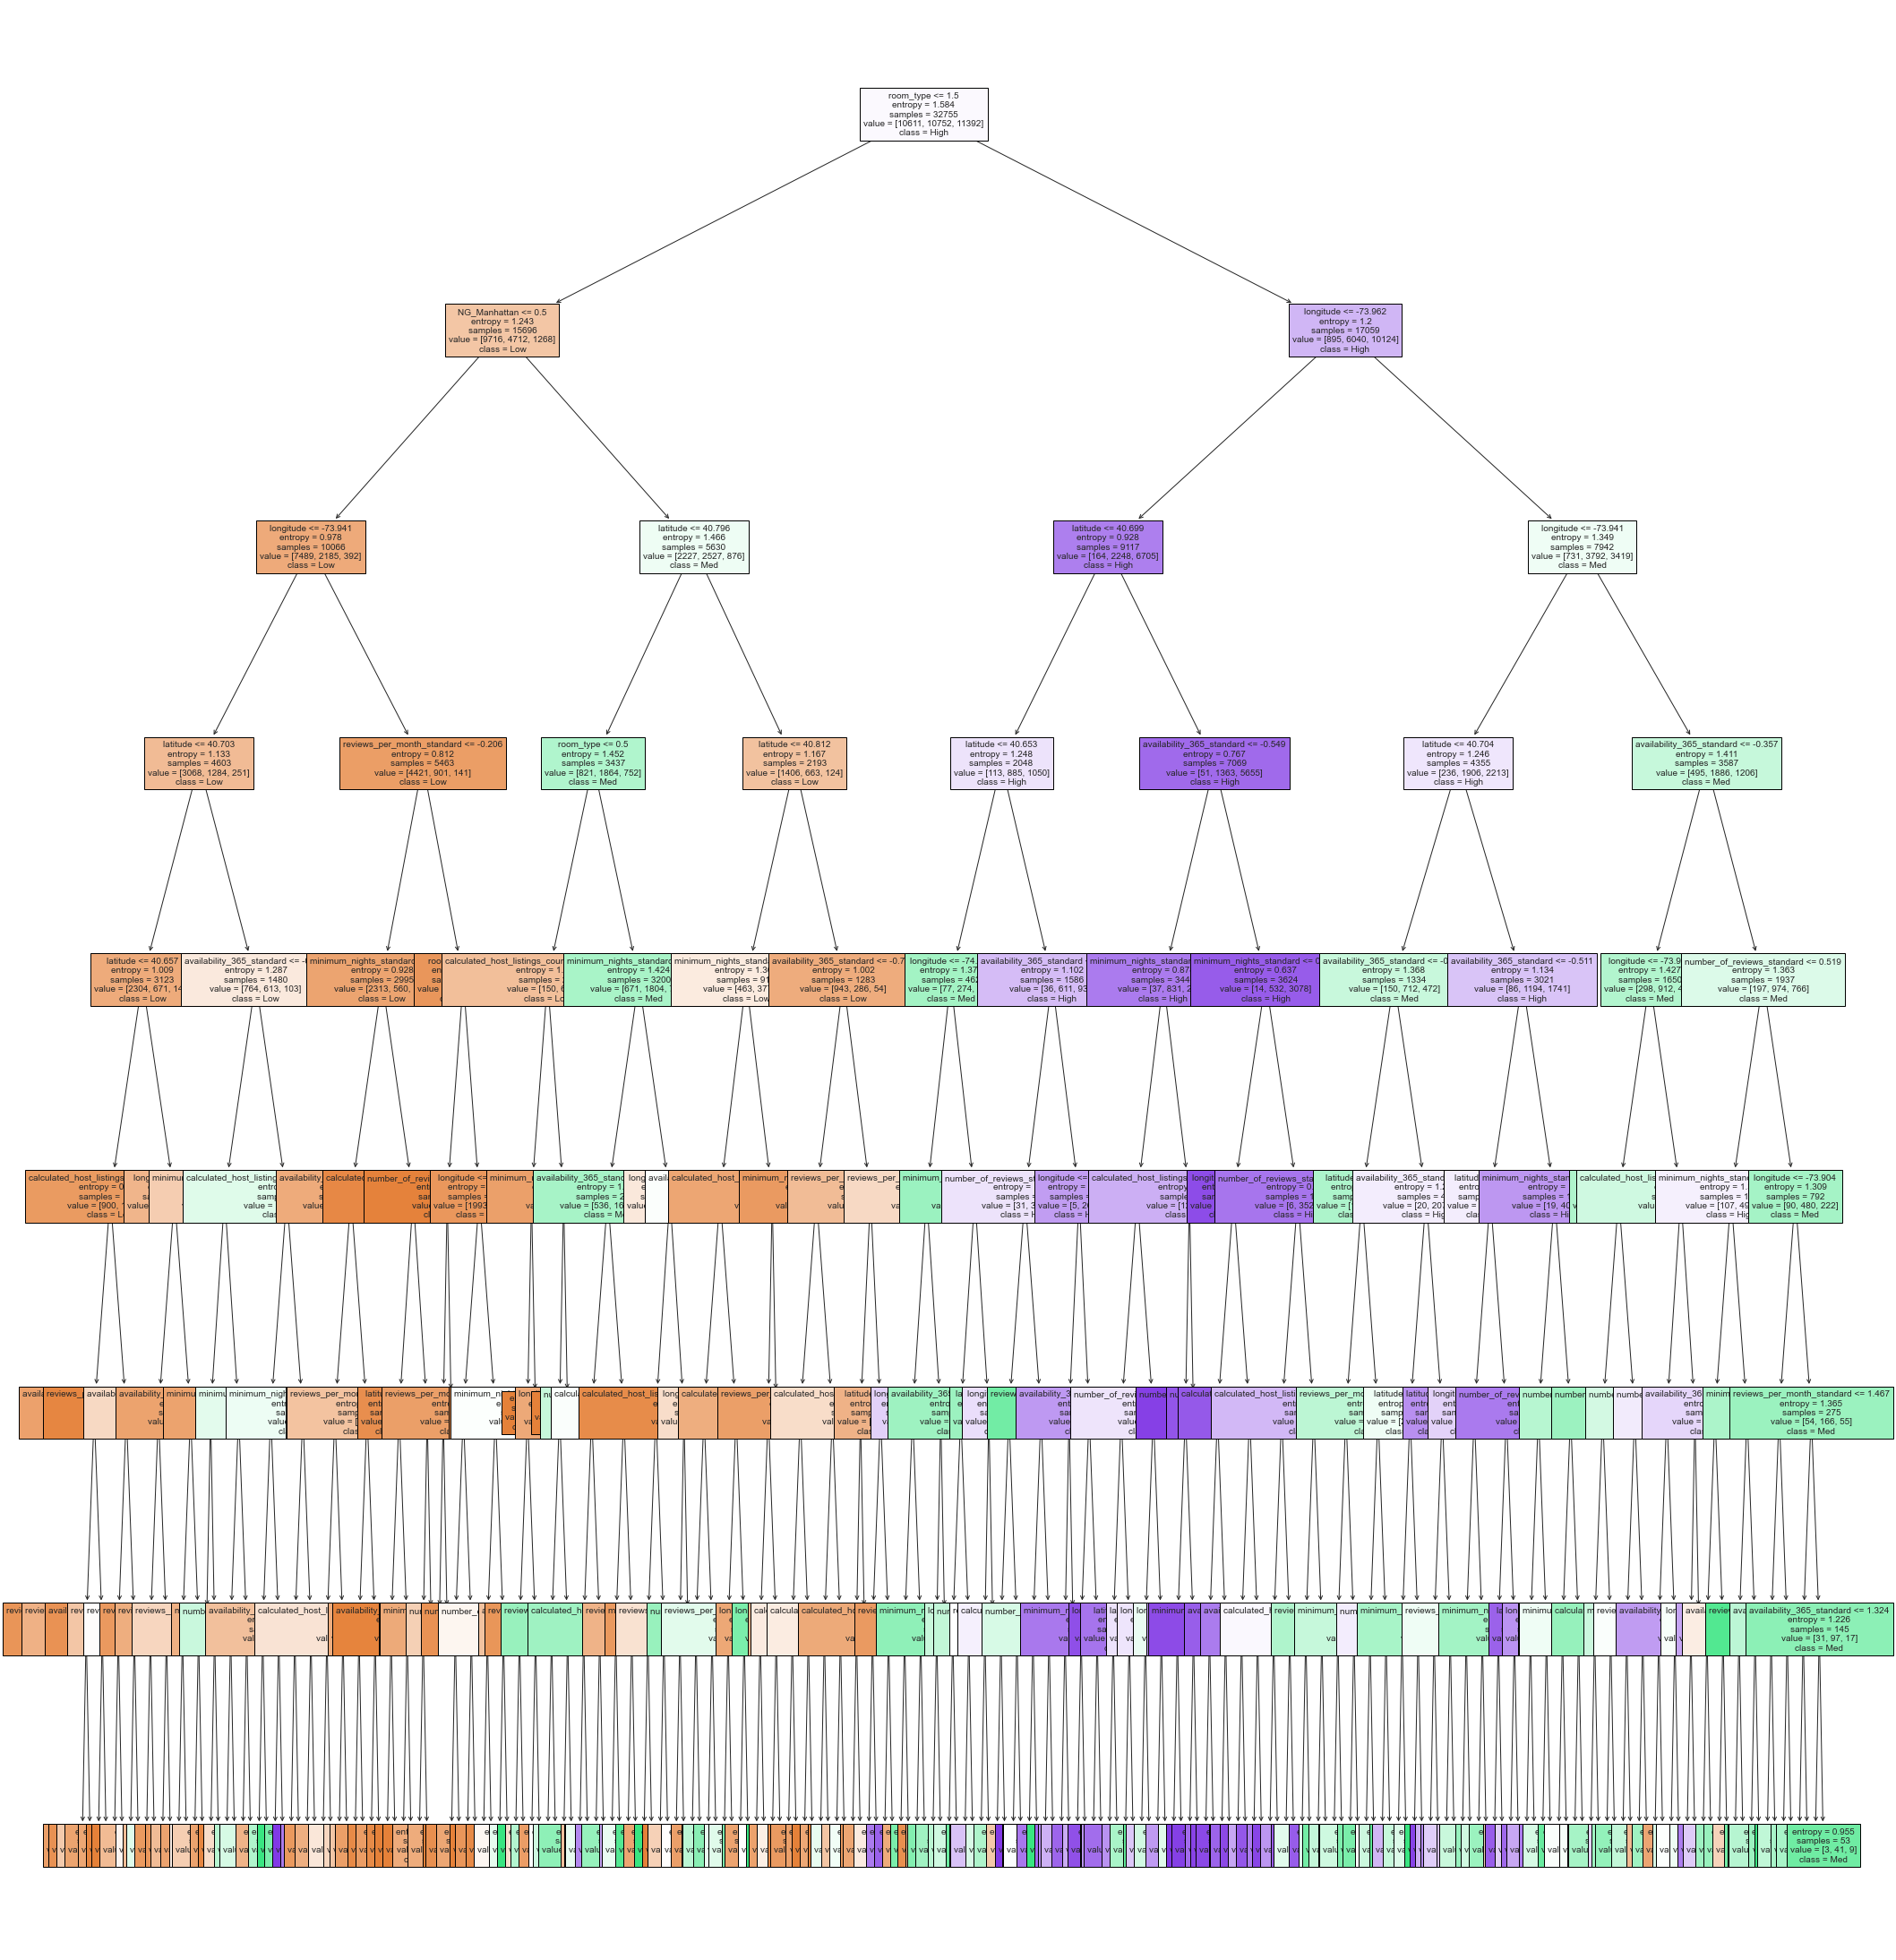

In [96]:
classes=[ 'Low','Med', 'High']
get_dt_graph(best_clf, classes)

In [97]:
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

In [102]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [101]:
from utils_func import plot_confusions_matrix

<module 'matplotlib.pyplot' from '/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/matplotlib/pyplot.py'>

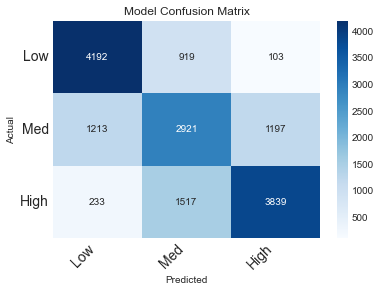

In [103]:
print_confusion_matrix(cm, class_names = ['Low','Med', 'High'])

In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Low','Med', 'High']))

              precision    recall  f1-score   support

         Low       0.74      0.80      0.77      5214
         Med       0.55      0.55      0.55      5331
        High       0.75      0.69      0.72      5589

    accuracy                           0.68     16134
   macro avg       0.68      0.68      0.68     16134
weighted avg       0.68      0.68      0.68     16134



In [172]:
def plot_decision_boundary(pred_func, pad: float = 1.0, h: float = 0.1):
    # Set min and max values and give it some padding
    x0_min, x0_max = np.round(X.iloc[:,0].min())-pad, np.round(X.iloc[:,0].max()+pad)
    x1_min, x1_max = np.round(X.iloc[:,1].min())-pad, np.round(X.iloc[:,1].max()+pad)
    x0_axis_range = np.arange(x0_min,x0_max, h)
    x1_axis_range = np.arange(x1_min,x1_max, h)
    xx0, xx1 = np.meshgrid(x0_axis_range, 
                           x1_axis_range)
    #reshaping into 2D array 
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    # Predict the function value for the whole gid
    yyhat = pred_func(np.c_[xx0.ravel(), xx1.ravel()])
    yyhat = yyhat.reshape(xx0.shape)
    # Plot the contour and training examples
    plt.contourf(xx0, xx1, yyhat, cmap=plt.cm.Spectral)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Spectral)


In [173]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=4,
                       min_samples_split=4, random_state=42)

In [174]:
dt.fit(X_train_db, y_train_db)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=4,
                       min_samples_split=4, random_state=42)

In [175]:
dt.predict(X_train_db)

array([2, 2, 2, ..., 2, 2, 1])

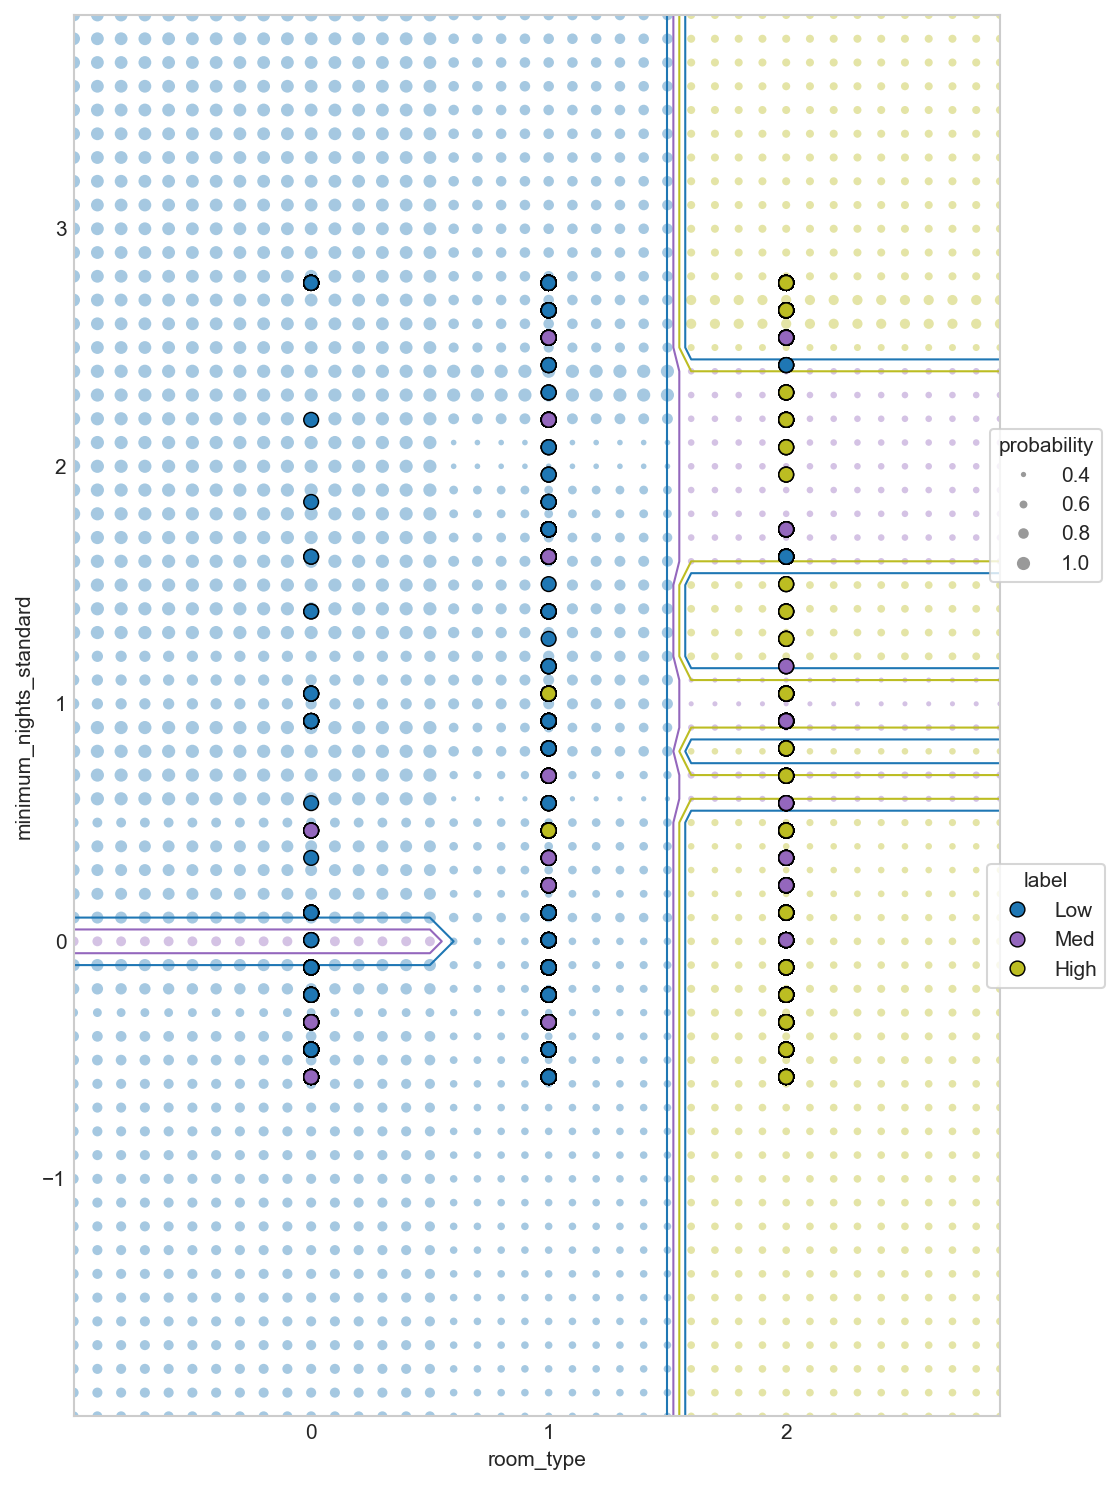

In [177]:
decision_boundary_plot(dt, X_train_db, y_train_db, classes=[ 'Low','Med', 'High'], h=0.1, prob_dot_scale=40, prob_dot_scale_power=2, true_dot_size=50, pad=1.0)

In [178]:
from sklearn.tree import export_text
tree_rules = export_text(best_clf, feature_names=list(X_train.columns))


In [179]:
tree_rules

'|--- room_type <= 1.50\n|   |--- NG_Manhattan <= 0.50\n|   |   |--- longitude <= -73.94\n|   |   |   |--- latitude <= 40.70\n|   |   |   |   |--- latitude <= 40.66\n|   |   |   |   |   |--- calculated_host_listings_standard <= 0.70\n|   |   |   |   |   |   |--- availability_365_standard <= -0.23\n|   |   |   |   |   |   |   |--- reviews_per_month_standard <= -0.78\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |   |   |--- reviews_per_month_standard >  -0.78\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |   |--- availability_365_standard >  -0.23\n|   |   |   |   |   |   |   |--- reviews_per_month_standard <= -0.57\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |   |   |--- reviews_per_month_standard >  -0.57\n|   |   |   |   |   |   |   |   |--- class: 0\n|   |   |   |   |   |--- calculated_host_listings_standard >  0.70\n|   |   |   |   |   |   |--- reviews_per_month_standard <= -0.62\n|   |   |   |   |   |   |   |--- a

1. What might be the motivation for a decision tree classifier?
2. What is the “action” that should be taken given the results of this prediction?
3. Who is the best immediate person(s) to make use of the results of your prediction?
4. What is the potential payoff of this prediction for an organization? (e.g. costs or e ciency).
5. Do your QuAMs results change your problem? If so, how and why? If not, please explain.
